<a href="https://colab.research.google.com/github/seismosmsr/hawaii_soils/blob/main/Hawaii_Soils_Simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
install.packages('sf')
install.packages('raster')
install.packages('exactextractr')
install.packages("googledrive")
install.packages("googletoken")
install.packages("DBI")
install.packages("RSQLite")
install.packages("RPostgreSQL")
install.packages("terra")
install.packages('randomForest')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘proxy’, ‘e1071’, ‘wk’, ‘classInt’, ‘Rcpp’, ‘s2’, ‘units’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘sp’, ‘terra’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Warning message:
“package ‘googletoken’ is not available for this version of R

A version of this package for your version of R might be available elsewhere,
see the ideas at
https://cran.r-project.org/doc/manuals/r-patched/R-admin.html#Installing-packages”
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the

In [2]:
library(ggplot2)
library(sf)
library(magrittr)
library(data.table)
library(raster)
library(exactextractr)
library(googledrive)
library(DBI)
library(terra)
library(randomForest)
library(parallel)

Linking to GEOS 3.10.2, GDAL 3.4.3, PROJ 8.2.1; sf_use_s2() is TRUE

Loading required package: sp

terra 1.7.55


Attaching package: ‘terra’


The following object is masked from ‘package:data.table’:

    shift


The following objects are masked from ‘package:magrittr’:

    extract, inset


randomForest 4.7-1.1

Type rfNews() to see new features/changes/bug fixes.


Attaching package: ‘randomForest’


The following object is masked from ‘package:ggplot2’:

    margin




In [3]:
drive_auth(use_oob = TRUE, cache = FALSE)

Please point your browser to the following url: 

https://accounts.google.com/o/oauth2/v2/auth?client_id=603366585132-frjlouoa3s2ono25d2l9ukvhlsrlnr7k.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&redirect_uri=https%3A%2F%2Fwww.tidyverse.org%2Fgoogle-callback%2F&response_type=code&state=45f2192d29f194ee3d963e6d6af0398e&access_type=offline&prompt=consent



Enter authorization code: eyJjb2RlIjoiNC8wQWZKb2hYbC1DdW9xeWhYZUNOMEVHTWRHYTdMLVJlUmh4bW5FYmF5dmRfYXp1U1ZIN2hfVEZZWEhDeERCeXlOMHU0YUlCZyIsInN0YXRlIjoiNDVmMjE5MmQyOWYxOTRlZTNkOTYzZTZkNmFmMDM5OGUifQ==


In [37]:
# https://drive.google.com/file/d/1ryTzWz0t9mgI5ynPvMzM21D135dLJvWv/view?usp=drive_link
# Updated: https://drive.google.com/file/d/1-dAAC42MM2BrShxXR_SUhavcawIHYy6B/view?usp=drive_link
drive_download(as_id('1-dAAC42MM2BrShxXR_SUhavcawIHYy6B'), path = paste0('/content/fia.csv'), overwrite = TRUE)
fia_dt <-  st_read('/content/fia.csv') %>% st_as_sf(coords = c("LON","LAT"), crs = 4326) %>% data.table
fia_dt$county_name <- fia_dt$County.Name

File downloaded:

• 2023_11_01FIA_soildepths.csv <id: 1-dAAC42MM2BrShxXR_SUhavcawIHYy6B>

Saved locally as:

• /content/fia.csv



Reading layer `fia' from data source `/content/fia.csv' using driver `CSV'


Warning message:
“no simple feature geometries present: returning a data.frame or tbl_df”


In [17]:
# https://drive.google.com/file/d/1j4B8qx1S0nHLSYrnRVRckwFTX9f2z1nb/view?usp=drive_link
# updated: https://drive.google.com/file/d/1LZQIykiIRmkIv-Ygy24rAN1ohmGOG1rY/view?usp=drive_link
drive_download(as_id('1LZQIykiIRmkIv-Ygy24rAN1ohmGOG1rY'), path = "/content/250_summary_grid_dt.gpkg", overwrite = TRUE)
grid_dt <- st_read("/content/250_summary_grid_dt.gpkg") %>% st_transform(4326) %>% data.table()

File downloaded:

• 250_summary_grid_dt.gpkg <id: 1LZQIykiIRmkIv-Ygy24rAN1ohmGOG1rY>

Saved locally as:

• /content/250_summary_grid_dt.gpkg



Reading layer `250_summary_grid_dt' from data source 
  `/content/250_summary_grid_dt.gpkg' using driver `GPKG'
Simple feature collection with 227561 features and 38 fields
Geometry type: POINT
Dimension:     XY
Bounding box:  xmin: 57161.36 ymin: 16952.32 xmax: 572661.4 ymax: 381202.3
Projected CRS: NAD_1983_HARN_StatePlane_Hawaii_1_FIPS_5101


In [18]:
grid_dt <- grid_dt[trees > 0.5 & !is.na(agbd_m) &!is.na(agbd_sd)& !is.na(aet)]

In [19]:
grid_dt$agbd_n <- grid_dt$agbd_n %>% as.numeric
grid_dt$agbd_sd <- grid_dt$agbd_sd %>% as.numeric
grid_dt$agbd_m <- grid_dt$agbd_m %>% as.numeric

In [39]:
fia_dt$SOC_Mg_Ha <- fia_dt$SOC_Mg_Ha %>% as.numeric

Warning message in fia_dt$SOC_Mg_Ha %>% as.numeric:
“NAs introduced by coercion”


In [111]:
grid_int_dt  <- fia_dt$geom %>% st_transform(4135) %>% st_buffer(10000) %>% st_transform(4326) %>% st_intersects(grid_dt$geom)

In [112]:
rm_vec <- (grid_int_dt %>% lapply(length) %>% unlist) > 0
grid_int_dt <- grid_int_dt[rm_vec]
fia_dt <- fia_dt[rm_vec,]

In [42]:
names(grid_dt)

[1] "id"                 "left"               "top"               
 [4] "right"              "bottom"             "water"             
 [7] "trees"              "grass"              "flooded_vegetation"
[10] "crops"              "shrub_and_scrub"    "built"             
[13] "bare"               "snow_and_ice"       "elevation"         
[16] "landform"           "SRTM_mTPI"          "aet"               
[19] "def"                "pdsi"               "pet"               
[22] "pr"                 "ro"                 "soil"              
[25] "srad"               "swe"                "tmmn"              
[28] "tmmx"               "vap"                "vpd"               
[31] "vs"                 "agbd_m"             "agbd_sd"           
[34] "agbd_n"             "majorcomposition"   "age_years"         
[37] "Age_Class"          "geom"               "age_class"

In [43]:
grid_dt$age_years[grid_dt$age_years %>% is.na ] <- -2
grid_dt$age_class[grid_dt$age_class %>% is.na ] <- 'Unknown'

Warning message in `[<-.factor`(`*tmp*`, grid_dt$age_class %>% is.na, value = "Unknown"):
“invalid factor level, NA generated”


In [44]:
grid_dt %>% names

[1] "id"                 "left"               "top"               
 [4] "right"              "bottom"             "water"             
 [7] "trees"              "grass"              "flooded_vegetation"
[10] "crops"              "shrub_and_scrub"    "built"             
[13] "bare"               "snow_and_ice"       "elevation"         
[16] "landform"           "SRTM_mTPI"          "aet"               
[19] "def"                "pdsi"               "pet"               
[22] "pr"                 "ro"                 "soil"              
[25] "srad"               "swe"                "tmmn"              
[28] "tmmx"               "vap"                "vpd"               
[31] "vs"                 "agbd_m"             "agbd_sd"           
[34] "agbd_n"             "majorcomposition"   "age_years"         
[37] "Age_Class"          "geom"               "age_class"

In [45]:
grid_dt$age_class %>%  is.na %>% table

.
 TRUE 
67102 

In [85]:
grid_dt$age_class <- NULL

In [86]:
grid_dt$max <- NULL

grid_dt$landform <- grid_dt$landform  %>% as.character
grid_dt$majorcomposition <- grid_dt$majorcomposition  %>% as.character
grid_dt$Age_Class <- grid_dt$Age_Class  %>% as.character

grid_dt$landform[is.na(grid_dt$landform)] <-'Unknown'
grid_dt$majorcomposition[is.na(grid_dt$majorcomposition)] <-'Unknown'
grid_dt$Age_Class[is.na(grid_dt$Age_Class)] <-'Unknown'

grid_dt$landform <-  grid_dt$landform %>% factor
grid_dt$majorcomposition <- grid_dt$majorcomposition %>% factor
grid_dt$Age_Class <- grid_dt$Age_Class %>% factor


Warning message in set(x, j = name, value = value):
“Column 'max' does not exist to remove”


In [55]:
fia_dt$DEPTH_UPPER <- fia_dt$LAYER_TYPE %>% gsub('MINERAL_SOIL_','',.) %>% gsub('_CM','',.) %>% strsplit('_') %>% lapply(function(x){x[1]}) %>% unlist %>% as.numeric
fia_dt$DEPTH_LOWER <- fia_dt$LAYER_TYPE %>% gsub('MINERAL_SOIL_','',.) %>% gsub('_CM','',.) %>% strsplit('_') %>% lapply(function(x){x[2]}) %>% unlist %>% as.numeric

In [65]:
fia_dt$DEPTH_LOWER %>% is.na() %>% table
fia_dt$DEPTH_UPPER %>% is.na() %>% table

.
FALSE 
  659 

.
FALSE 
  659 

In [133]:
# fia_length <- fia_dt$PLOT %>% split(.)



[1]  1168  1168  1168  1168  1148   379   379   379   379   379  1793  1793
 [13]  1793  1793  1793  1707  1707  1707  1707  1707  3087  3087  3087  3087
 [25]  3087  4887  4887  4887  4887  4887  4908  4908  4908  4908  1984  1984
 [37]  1984  1984  1984  2167  2167  2167  2167  2167  4993  6211  6211  6211
 [49]  6211  6211  2290  2290  2290  2290  2290  6721  6721  6721  6150  8891
 [61]  8040  8040  8040  8040  8040  7676  7676  7676  7676  7676  5244  8673
 [73]  8673  8673  8673  8673  8234  8234  8234  8234  8234  9590  9590  9590
 [85]  9590  9590  9490 10272 10272 10272 10272 11013 11013 12746 12746 12746
 [97] 12746 12746 12257 12257 12257 12257 12257 12794 12794 12794 12794 12794
[109] 10491 10491 10491 10491 10491 12524 14196 14196 14196 12963 12963 12963
[121] 12963 12963 13540 13540 15008 15008 15008 15008 15008 14646 14862 14862
[133] 14862 14862 14862 16148 16148 14970 18017 17978 17978 16984 18296 18296
[145] 18296 18296 18296 19639 19639 19639 19639 19639 18098 18098 18098 18098
[157] 18098 18704 18704 18704 18704 19375 19375 21321 21321 21321 21321 17929
[169] 15951 15951 15951 19970 19970 20635 20635 20635 20176 20176 20176 16574
[181] 18901 18901 18901 18901 18901 21314 20473 20473 20473 20473 20473 21013
[193] 21013 21013 21013 21013 20011 19625 19625 19625 19625 19625 21234 21234
[205] 21234 22183 22183 24445 24445 24445 24445 24445 24796 24796 24796 24796
[217] 24796 23577 23577 23577 23577 23577 24298 24298 24298 24298 24298 26917
[229] 26258 26258 26258 26258 26258 26946 29221 29221 29221 29243 29243 29243
[241] 29243 29243 28344 28344 28344 28344 28344 29178 28454 28454 28454 28454
[253] 28454 30780 30780 30780 30780 30780 28199 32603 32603 32603 32603 32603
[265] 30448 30631 30631 32321 32321 32321 32321 31918 31918 31918 31918 31918
[277] 34437 34437 34437 34437 34437 35921 35921 35921 35921 35921 36234 36234
[289] 34145 34145 34145 34833 34833 34833 34833 34833 33671 33671 33671 33671
[301] 33671 37191 37191 37191 37191 37191 37430 36008 36008 36008 36008 36008
[313] 37487 37875 37875 37875 37875 37875 42919 35617 35617 41484 34706 34706
[325] 34706 34706 34706 41983 38583 42041 34838 41318 41318 43410 42744 43832
[337] 44789 44789 45233 41982 41986 41986 44800 41510 41053 49706 45761 51003
[349] 46544 47923 40465 47256 45913 45913 45913 45913 45913 50356 43493 49930
[361] 46640 48637 48637 48637 48637 48637 45538 48607 48607 48607 48607 48607
[373] 53319 52182 52182 52182 52182 52182 44660 44660 44660 44660 44660 51362
[385] 47724 51086 48545 46985 48964 48964 48964 48964 48964 47286 47286 53032
[397] 53032 53032 53032 56199 49017 51185 52770 56468 56468 56468 56468 56468
[409] 47680 50074 57938 53389 58817 58819 58819 58819 56008 53847 62145 57252
[421] 57252 57252 57252 57252 55726 55726 59344 62158 62158 62158 62158 62158
[433] 57856 62136 62136 63700 62184 62184 62184 62184 62184 60391 62584 62584
[445] 62584 62584 63542 63440 61121 61121 61121 61121 61121 62915 62915 63037
[457] 63037 63037 61906 64743 65099 66174 65644 64987 44171 44171 44171 44171
[469] 44171 41147 56882 56882 47697 47697 47697 47697 47697 37590 35165 35165
[481] 35165 35165 35165 37510 43475 43475 43475 43475 43475 61672 43895 64678
[493] 54370 43518 65225 65225 65225 65225 65225 32916 32916 47936 29451 29451
[505] 29451 29451 29451 63745 31317 31317 31317 31317 31317 48964 30971 30971
[517] 30971 30971 30971 41412 28743 28743 28743 28743 35877 35877 35877 35877
[529] 35877 60349 36383 63411 41257 37385 57092 57092 57092 57092 57092 56543
[541] 47067 49441 58464 58464 58464 58464 58464 43080 37441 32732 32732 32732
[553] 32732 32732 32992 32992 32992 32992 32992 38729 51446 60360 56405 56405
[565] 37538 57094 46891 25161 50370 37314 63684 58403 53441

In [156]:
  grid_int_dt_split <- grid_int_dt %>% split(fia_dt$PLOT)

  sample_vec <- grid_int_dt_split %>% lapply(function(x){sample(x[[1]],1) %>% rep(length(x))}) %>% unlist %>% as.numeric

  rf_dt <- data.table(fia_dt[,c('PLOT','SOC_Mg_Ha','DEPTH_UPPER','DEPTH_LOWER','county_name')], grid_dt[sample_vec,])

  x_var <- c('DEPTH_UPPER','DEPTH_LOWER',(rf_dt %>% names)[-c(1,2,3,4,5,6,7,8,9,10,ncol(rf_dt) )])
  # print(x_var)
  rf_form <- as.formula(paste0('SOC_Mg_Ha~',paste(x_var,collapse = '+')))

  rf_dt <-  rf_dt[complete.cases(rf_dt[,-c(ncol(rf_dt)),with=F]),]
  rf_dt <-  rf_dt[!is.na(SOC_Mg_Ha),]

  # print(nrows(rf_dt))
  rf_terra <- randomForest(rf_form,rf_dt,verbose=T)

  rf_imp_dt <- rf_terra$importance %>% t %>% data.table

  names(rf_imp_dt) <-paste0('var_imp_',names(rf_imp_dt))

  out_dt <- data.table(rf_dt,data.table(predicted = rf_terra$predicted),rf_imp_dt[rep(1,nrow(rf_dt)),])



  out_dt$r2_depth <- rf_terra$rsq[500]

  out_dt$r2_plot <-(lm(SOC_Mg_Ha~predicted,out_dt[,list(SOC_Mg_Ha = sum(SOC_Mg_Ha),predicted = sum(predicted)),by=PLOT]) %>% summary())$r.squared

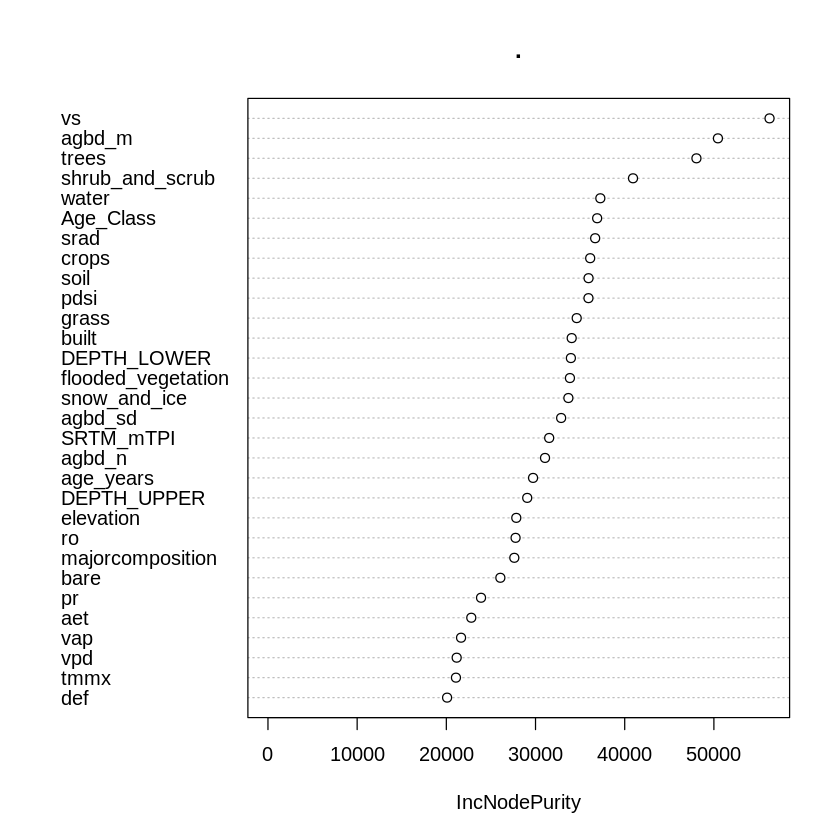

In [98]:
# rf_terra %>% varImpPlot

In [ ]:
# for( i in 1:30){
cl <-makeCluster(8)
sim_dt <-
1:1000 %>% parLapply(cl,.,function(m,fia_dt,grid_dt,grid_int_dt){
  library(sf)
  library(magrittr)
  library(data.table)
  library(raster)
  library(exactextractr)
  library(terra)
  library(randomForest)

  grid_int_dt_split <- grid_int_dt %>% split(fia_dt$PLOT)

  sample_vec <- grid_int_dt_split %>% lapply(function(x){sample(x[[1]],1) %>% rep(length(x))}) %>% unlist %>% as.numeric

  rf_dt <- data.table(fia_dt[,c('PLOT','SOC_Mg_Ha','DEPTH_UPPER','DEPTH_LOWER','county_name')], grid_dt[sample_vec,])

  x_var <- c('DEPTH_UPPER','DEPTH_LOWER',(rf_dt %>% names)[-c(1,2,3,4,5,6,7,8,9,10,ncol(rf_dt) )])
  # print(x_var)
  rf_form <- as.formula(paste0('SOC_Mg_Ha~',paste(x_var,collapse = '+')))

  rf_dt <-  rf_dt[complete.cases(rf_dt[,-c(ncol(rf_dt)),with=F]),]
  rf_dt <-  rf_dt[!is.na(SOC_Mg_Ha),]

  # print(nrows(rf_dt))
  rf_terra <- randomForest(rf_form,rf_dt,verbose=T)

  rf_imp_dt <- rf_terra$importance %>% t %>% data.table

  names(rf_imp_dt) <-paste0('var_imp_',names(rf_imp_dt))

  out_dt <- data.table(rf_dt,data.table(predicted = rf_terra$predicted),rf_imp_dt[rep(1,nrow(rf_dt)),])



  out_dt$r2_depth <- rf_terra$rsq[500]

  out_dt$r2_plot <-(lm(SOC_Mg_Ha~predicted,out_dt[,list(SOC_Mg_Ha = sum(SOC_Mg_Ha),predicted = sum(predicted)),by=PLOT]) %>% summary())$r.squared

  return(out_dt[county_name %in% 'Hawaii'])
  },fia_dt,grid_dt,grid_int_dt) %>%
  rbindlist
stopCluster(cl)

# sim_dt %>% st_write(paste0("/content/sim_results_Hawaii_10000m_Run",i,".gpkg"), append=FALSE)

# drive_upload(paste0("/content/sim_results_Hawaii_10000m_Run",i,".gpkg"), path = as_id("1uVZCzCb5gRE8wfZckspRuKz1TQd5LpeM"))
# }

In [146]:
sim_dt %>% head

PLOT,SOC_Mg_Ha,DEPTH_UPPER,DEPTH_LOWER,county_name,id,left,top,right,bottom,⋯,var_imp_vap,var_imp_vpd,var_imp_vs,var_imp_agbd_m,var_imp_agbd_sd,var_imp_agbd_n,var_imp_majorcomposition,var_imp_age_years,var_imp_Age_Class,r2
<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2159,128.44035,0,20,Hawaii,2568074,476661.4,145202.3,476911.4,145452.3,⋯,23654.43,25880.17,41244.31,24506.67,21264.28,20454.92,12537.7,19708.9,11609.33,0.2621513
2159,130.21346,20,40,Hawaii,2568074,476661.4,145202.3,476911.4,145452.3,⋯,23654.43,25880.17,41244.31,24506.67,21264.28,20454.92,12537.7,19708.9,11609.33,0.2621513
2159,28.53641,40,60,Hawaii,2568074,476661.4,145202.3,476911.4,145452.3,⋯,23654.43,25880.17,41244.31,24506.67,21264.28,20454.92,12537.7,19708.9,11609.33,0.2621513
2159,56.95289,60,80,Hawaii,2568074,476661.4,145202.3,476911.4,145452.3,⋯,23654.43,25880.17,41244.31,24506.67,21264.28,20454.92,12537.7,19708.9,11609.33,0.2621513
2159,77.09995,80,100,Hawaii,2568074,476661.4,145202.3,476911.4,145452.3,⋯,23654.43,25880.17,41244.31,24506.67,21264.28,20454.92,12537.7,19708.9,11609.33,0.2621513
2167,70.85956,0,20,Hawaii,2587635,479911.4,139702.3,480161.4,139952.3,⋯,23654.43,25880.17,41244.31,24506.67,21264.28,20454.92,12537.7,19708.9,11609.33,0.2621513


In [ ]:
# Write to GeoPackage
sim_dt %>% st_write("/content/sim_results_Hawaii_10000m_Run1.gpkg", append=FALSE)

In [ ]:
# https://drive.google.com/drive/folders/1uVZCzCb5gRE8wfZckspRuKz1TQd5LpeM?usp=drive_link
drive_upload("/content/sim_results_Hawaii_10000m_Run1.gpkg", path = as_id("1uVZCzCb5gRE8wfZckspRuKz1TQd5LpeM"))

In [ ]:
# sim_dt

`geom_smooth()` using formula = 'y ~ x'


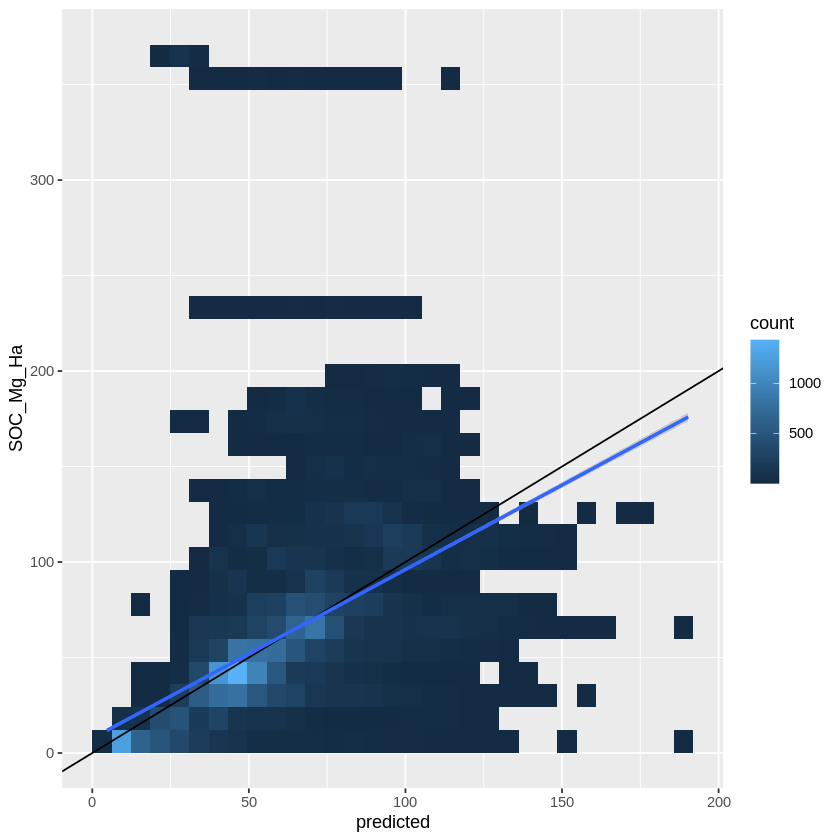

In [151]:
sim_dt %>%
  ggplot(aes(y=SOC_Mg_Ha,x=predicted))+
    geom_bin2d() +
    geom_abline()+
    geom_smooth(method = 'lm')